In [1]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

In [2]:
start = '2015-01-01'; end = '2019-12-31'

In [33]:
# To find portfolio optimization, we will be using stocks from 4 companies, namely, Apple, Nike, Google and Amazon from 2015 to 2019.

# we will learn to calculate the weights of assets for each one. 
# Then, we will calculate the expected returns, minimum variance portfolio, optimal risky portfolio and efficient frontier. 

In [35]:
# COVARIANCE
# The first step is to obtain a covariance and correlation matrix to understand how different assets behave with respect to each other. 

# To find the covariance and correlation matrix for more than 2 assets, we will use the .cov() and .corr() functions.

# CORRELATION ranges from -1 to 1.

# A correlation of -1 means negative relation, i.e, if correlation between Asset A and Asset B is -1, if Asset A increases, Asset B decreases.
# A correlation of +1 means positive relation, i.e, if correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases.
# A correlation of 0 means no relation, i.e, if correlation between Asset A and Asset B is 0, they dont have any effect on each other.

In [36]:
#PORTFOLIO VARIANCE
# The formula for calculating portfolio variance differs from the usual formula of variance. It looks like this:

$$\sigma^2(Rp) = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j COV(R_i, R_j)$$

In [37]:
# Here, wi and wj denote weights of all assets from 1 to n (in our case from 1 to 4) and COV(Ri, Rj) is the covariance of the two assets denoted by i and j.

# The simplest way to do this complex calculation is defining a list of weights and multiplying this list horizontally and vertically with our covariance matrix.

In [38]:
# Let’s define a random list of weights for all 4 assets. Remember that sum of weights should always be 1.

In [6]:
def get_stock_data(start=start, end=end):   
    # Read Data
    df = yf.download(['AAPL', 'NKE', 'GOOGL', 'AMZN'], start=start, end=end)
    df = df['Adj Close']

    #Log of percentge change
    cov_matrix = df.pct_change().apply(lambda x: np.log(x+1)).cov()
    corr_matrix = df.pct_change().apply(lambda x: np.log(x+1)).corr()

    #Random weight portfolio variance
    w =  {'AAPL': 0.1, 'NKE': 0.2, 'GOOGL': 0.5, 'AMZN': 0.2}
    port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
    
    return df, cov_matrix, corr_matrix, port_var


In [13]:
df, cov_matrix, corr_matrix, port_var = get_stock_data()

[*********************100%***********************]  4 of 4 completed


In [40]:
# The mean of returns (given by change in prices of asset stock prices) give us the expected returns of that asset.
# The sum of all individual expected returns further multiplied by the weight of assets give us expected return for the portfolio.

# Note that we use the resample() function to get yearly returns. The argument to function, ‘Y’, denotes yearly.
# If we dont perform resampling, we will get daily returns.

In [16]:
#yearly return for individual assets
ind_er = df.resample('Y').last().pct_change().mean()
ind_er

AAPL     0.280256
AMZN     0.472163
GOOGL    0.217606
NKE      0.191307
dtype: float64

In [42]:
# Plotting the efficient frontier
# This is the aim of going through all the topics above, to plot the efficient frontier. 
# Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘volatility’ on the X-axis. 
# It shows us the maximum return we can get for a set level of volatility, or conversely, the volatility that we need to accept for certain level of returns.

# Lets take a look at the volatiltilty and returns of individual assets for a better understanding.

In [15]:
#volatility is given by the annual standard deviation
ann_sd = df.pct_change().apply(lambda x: np.log(x+1)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

AAPL     0.247816
AMZN     0.288673
GOOGL    0.235284
NKE      0.233888
dtype: float64

In [18]:
assets = pd.concat([ind_er, ann_sd], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AAPL,0.280256,0.247816
AMZN,0.472163,0.288673
GOOGL,0.217606,0.235284
NKE,0.191307,0.233888


In [43]:
# To plot the graph of efficient frontier, we need run a loop (run different trials). 
# In each iteration, the loop considers different weights for assets and calculates the return and volatility of that particular portfolio combination.
# We run this loop a 1000 times.

# To get random numbers for weights, we use the np.random.random() function. 
# But remember that the sum of weights must be 1, so we divide those weights by their cumulative sum.

In [19]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] #Define an empty array for portfolio volatility
p_weights = [] #Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000

for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) #Returns are the product of individual expected returns of asset and its

    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() #Portfolio Variance
    sd = np.sqrt(var) #Daily standard deviation
    ann_sd = sd*np.sqrt(250) #Annual standard deviation = volatility
    p_vol.append(ann_sd)

data = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

portfolios  = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,AAPL weight,AMZN weight,GOOGL weight,NKE weight
0,0.285403,0.197516,0.063678,0.301068,0.147367,0.487888
1,0.231682,0.188125,0.226391,0.033314,0.413732,0.326563
2,0.291801,0.194927,0.198049,0.288817,0.066982,0.446152
3,0.246629,0.196364,0.309426,0.053514,0.485522,0.151538
4,0.315983,0.203498,0.086126,0.408827,0.083423,0.421623


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

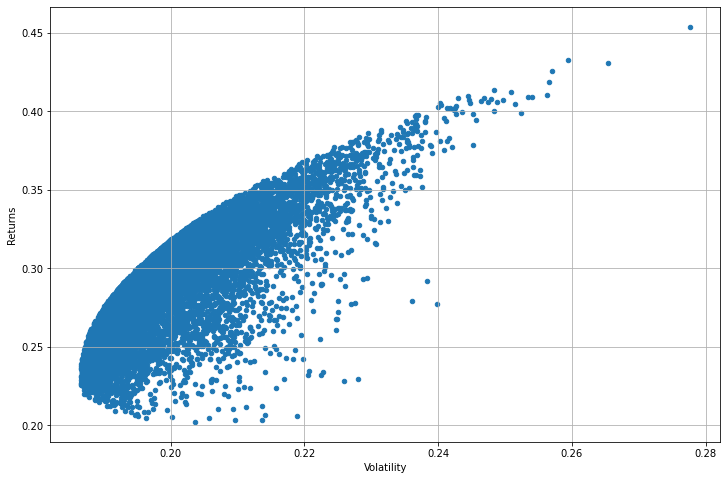

In [21]:
#plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', figsize=(12, 8), grid=True)

In [44]:
# You can see that there are a number of portfolios with different weights, returns and volatility. 
# Plotting the returns and volatility from this dataframe will give us the efficient frontier for our portfolio.

In [22]:
# How to read the Efficient Frontier?
# Each point on the line (left edge) represents an optimal portfolio of stocks that maximises the returns for any given level of risk.

# The point (portfolios) in the interior are sub-optimal for a given risk level. 
# For every interior point, there is another that offers higher returns for the same risk.

# On this graph, you can also see the combination of weights that will give you all possible combinations:

# Minimum volatility (left most point)
# Maximum returns (top most point)
# And everything in between.

In [23]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()] #ixdmin() is the minimum value of the column we pass in
min_vol_port 

Returns         0.231220
Volatility      0.186568
AAPL weight     0.271660
AMZN weight     0.027905
GOOGL weight    0.300840
NKE weight      0.399595
Name: 5133, dtype: float64

In [24]:
#The minimum volatility is in portfolio where the weights of AAPL, AMNZ, GOOGL, NKE are 27%, 2.7%, 30%, 40% respectively. 

In [25]:
#This plot can be plotted on the efficient frontier graph as shown below:

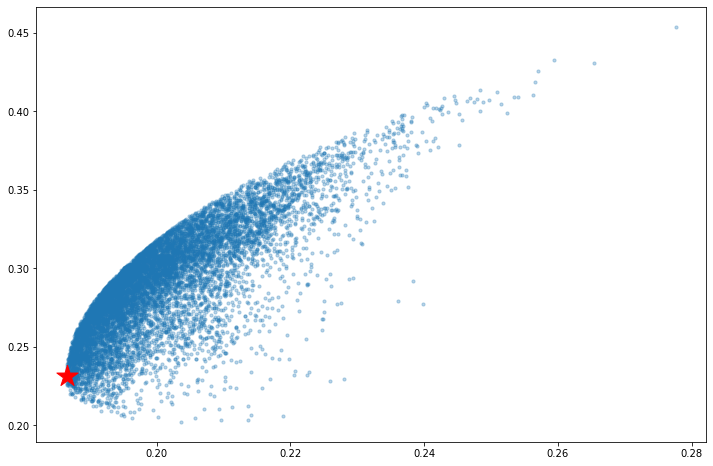

In [26]:
plt.subplots(figsize=(12, 8))
plt.scatter(portfolios['Volatility'], portfolios['Returns'], marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.show()

In [28]:
# The red star denotes the most efficient portfolio with minimum volatility.

# It is important to note that any point to the right of efficient frontier boundary is a sup-optimal portfolio.

# We found the portfolio with minimum volatility, but you will notice that the return on this portfolio is pretty low. 
# Any sensible investor wants to maximize his return, even if it is a tradeoff with some level of risk.

# And then we can use Sharpe Ratio to find optimal risky portfolio and finallt optimize our portfolio to the maximum.

In [29]:
# SHARPE RATIO
# The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. 
# Volatility is a measure of the price fluctuations of an asset or portfolio.

# The risk-free rate of return is the return on an investment with zero risk, meaning it’s the return investors could expect for taking no risk.

# The optimal risky portfolio is the one with the highest Sharpe ratio. The formula for this ratio is:

# Sharpe Ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return

# Below is the code for finding out portfolio with maximum Sharpe Ratio. 
# This portfolio is the optimized portfolio that we wanted to find. 
# We may define the risk-free rate to be 1% or 0.01.

In [30]:
risk_free_rate = 0.01
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-risk_free_rate)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns         0.405198
Volatility      0.240344
AAPL weight     0.229545
AMZN weight     0.688850
GOOGL weight    0.000224
NKE weight      0.081381
Name: 3695, dtype: float64

In [31]:
# You can notice that while the difference in risk between minimum volatility portfolio and optimal risky portfolio is around 6% (0.24 - 0.186), 
# the difference in returns is arround 17% (0.405 - 0.23).
# We can plot this point too on the graph of efficient frontier.

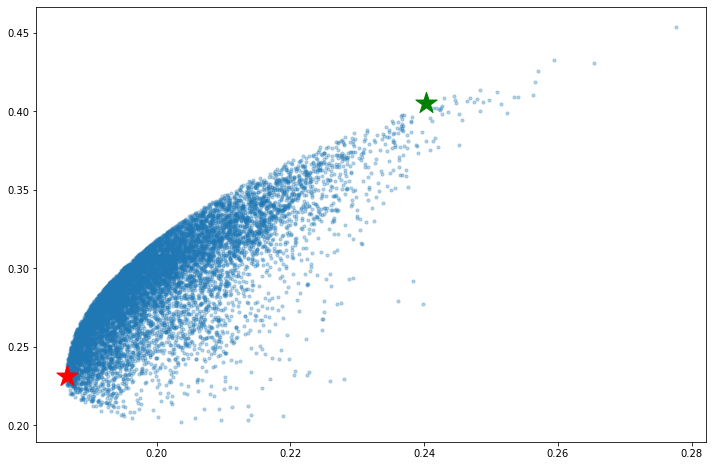

In [32]:
# Plotting optimal portfolio
plt.subplots(figsize=(12, 8))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)